# <font color="red"><center> TME 7 : Continuous Actions </center></font>

## Ce TME a pour objectif d’expérimenter l’approche DDPG pour environnements à actions continues.

In [31]:
import matplotlib
import matplotlib.pyplot as plt

import gym
#import gridworld
from gym import wrappers, logger
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from collections import deque
from tqdm import tqdm
from torch.autograd import Variable

## Réseaux de neurones

In [52]:
class Critic(nn.Module):
    def __init__(self, input_size, output_size, h1_size, h2_size):
        super(Critic, self).__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(input_size, h1_size),
            torch.nn.ReLU(),
            torch.nn.Linear(h1_size, h2_size),
            torch.nn.ReLU(),
            torch.nn.Linear(h2_size, output_size)
        )

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        y = self.seq(x)

        return y

class Actor(nn.Module):
    def __init__(self, input_size, output_size, h1_size, h2_size):
        super(Actor, self).__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(input_size, h1_size),
            torch.nn.ReLU(),
            torch.nn.Linear(h1_size, h2_size),
            torch.nn.ReLU(),
            torch.nn.Linear(h2_size, output_size),
            torch.nn.Tanh()
        )
        
    def forward(self, x):
        """
        Param state is a torch tensor
        """
        y = self.seq(x)

        return y

## Algorithme DDPG

In [82]:
class DDPG():
    
    def __init__(self, h1_size, h2_size, envm, capacity, batch_size, updates_count=500, episode_count=100, gamma=0.99, actor_lr=1e-4, critic_lr=1e-3, tau=1e-2):
        num_states = envm.observation_space.shape[0]
        num_actions = envm.action_space.shape[0]
        
        self.actor = Actor(num_states, num_actions, h1_size, h2_size)
        self.actor_target = Actor(num_states, num_actions, h1_size, h2_size)
        self.critic = Critic(num_states + num_actions, num_actions, h1_size, h2_size)
        self.critic_target = Critic(num_states + num_actions, num_actions, h1_size, h2_size)
        
        # We initialize the target networks as copies of the original networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
            
        self.episode_count = episode_count
        self.updates_count = updates_count
        self.envm = envm
        self.memory = deque(maxlen=capacity)
        self.batch_size = batch_size
        self.tau = tau
        self.gamma = gamma
        self.MSELoss = torch.nn.MSELoss()
        
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        
    def fit(self):
        
        all_rewards = []
        
        for _ in tqdm(range(self.episode_count)):
            
            rewards = 0
            state = self.envm.reset()
            done = False
            
            for _ in (range(self.updates_count)):

                actor = self.actor( torch.tensor(state, dtype=torch.float32 ) )
                eps = torch.randn(actor.size())
                action = torch.clamp(actor + eps, self.envm.action_space.low[0], self.envm.action_space.high[0])
                new_state, reward, done, _ = env.step(action.detach().numpy())
                
                rewards += reward
                self.memory.append([state, action.detach().numpy(), reward, new_state, done])

                if done:
                    break
                    
                state = new_state
                
                if self.batch_size < len(self.memory):
                        
                    minibatch = random.sample(self.memory, self.batch_size)
                    s = torch.tensor([mb[0] for mb in minibatch], dtype=torch.float32)
                    a = torch.tensor([mb[1] for mb in minibatch], dtype=torch.float32)
                    r = torch.tensor([mb[2] for mb in minibatch], dtype=torch.float32)
                    s_p = torch.tensor([mb[3] for mb in minibatch], dtype=torch.float32)
                    d = torch.tensor([mb[4] for mb in minibatch], dtype=torch.float32)
                    
                    y = r.reshape(r.shape[0], 1) + self.gamma * (1 - d.reshape(d.shape[0],1)) * self.critic_target(s_p, self.actor_target(s_p)) 

                    c = self.critic(s, a) 


                    loss = self.MSELoss(c, y)
                    self.critic_optimizer.zero_grad()
                    loss.backward()
                    self.critic_optimizer.step()

                    policy_loss = -self.critic(s, self.actor(s)).mean()
                    self.actor_optimizer.zero_grad()
                    policy_loss.backward()
                    self.actor_optimizer.step()

                    for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
                        target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

                    for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
                        target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
                            
            print("Reward cumulé pour cet épisode : ", rewards)
            all_rewards.append(rewards)
                
        return all_rewards

## Pendulum

In [ ]:
env_id = 'Pendulum-v0'
outdir = 'Pendulum-v0/random-agent-results'
envx = gym.make(env_id)
envx.verbose = True
env = envx
envm = wrappers.Monitor(envx, directory=outdir, force=True,
                       video_callable=False)


print(envm.observation_space.shape[0])
print(envm.action_space.shape[0])
print(envm.action_space.low[0])

h1_size = 256
h2_size = 256
capacity = 50000
batch_size = 128

agent = DDPG(h1_size, h2_size, envm, capacity, batch_size)

cr = agent.fit()

In [68]:
np.save("ddpg_pendulum", cr)

## Mountain Car

In [ ]:
env_id = 'MountainCarContinuous-v0'
outdir = 'MountainCarContinuous-v0/random-agent-results'
envx = gym.make(env_id)
envx.verbose = True
env = envx
envm = wrappers.Monitor(envx, directory=outdir, force=True,
                       video_callable=False)


print(envm.observation_space.shape[0])
print(envm.action_space.shape[0])
print(envm.action_space.low[0])

h1_size = 256
h2_size = 256
capacity = 50000
batch_size = 128

agent = DDPG(h1_size, h2_size, envm, capacity, batch_size)

cr2 = agent.fit()

In [69]:
np.save("ddpg_mountaincar", cr2)

## Lunar Lander

In [ ]:
env_id = 'LunarLanderContinuous-v2'
outdir = 'LunarLanderContinuous-v2/random-agent-results'
envx = gym.make(env_id)
envx.verbose = True
env = envx
envm = wrappers.Monitor(envx, directory=outdir, force=True,
                       video_callable=False)


print(envm.observation_space.shape[0])
print(envm.action_space.shape[0])
print(envm.action_space.low[0])

h1_size = 256
h2_size = 256
capacity = 50000
batch_size = 128

agent = DDPG(h1_size, h2_size, envm, capacity, batch_size)

cr3 = agent.fit()

In [86]:
np.save("ddpg_lunarlander", cr3)

No handles with labels found to put in legend.


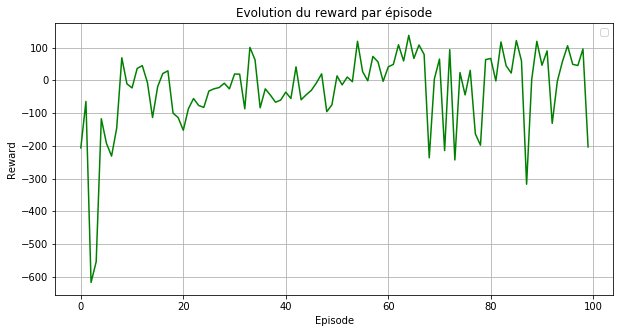

In [95]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()
ax.set(xlabel='Episode', ylabel='Reward',
       title='Evolution du reward par épisode')

#plt.plot(np.arange(len(cr)), cr, 'b' )

#plt.plot(np.arange(len(cr2)), cr2, 'r')

plt.plot(np.arange(len(cr3)), cr3, 'g' )


ax.legend()
plt.show()